# Extrusion force

This notebook process the raw extrusion force data. It takes in the time series of extrusion force, exit temperature and die swell data, and determine stable extrusion regimes based on these data.

## 0 Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path
from scipy.interpolate import CubicSpline, griddata
import matplotlib.colors as mcolors
from utils import *
import sys
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks

if sys.platform == "darwin":
    google_drive_base = Path("/Users/zhengyang/Library/CloudStorage/GoogleDrive-liuzy19911112@gmail.com/My Drive")
elif sys.platform == "win32":
    google_drive_base = Path(r"G:\我的云端硬盘")
else:
    google_drive_base = Path("~/Google Drive").expanduser().resolve()

from myimagelib import bestcolor

## 1 Time series

Load and plot the time series.

In [101]:
data_folder = google_drive_base / "Polymaker" / "003.挤出过程研究" / "003.挤出测试平台" / "实验数据" / "002.挤出力数据" / "PETG" / "G235-大理石"
filename = "20251205_111201_autosave.csv"
data = pd.read_csv(data_folder / filename)

In [102]:
data.head()

,hotend_temperature_C,die_temperature_C,feedrate_mms,measured_feedrate_mms,extrusion_force_N,die_diameter_px,meter_count_mm,time_s
0,249.61,229.29999,0.0,2.361405,4.07092,15.997540,8008.020833,1720.3
1,249.61,229.50000,0.0,1.820028,2.36278,15.378083,8008.020833,1720.4
2,249.62,229.50000,0.0,1.552743,1.66502,13.671755,8008.020833,1720.5
3,249.62,229.50000,0.0,0.819470,0.65660,13.671755,8008.020833,1720.6
4,249.64,229.50000,0.0,0.328574,0.37142,11.905176,8008.020833,1720.7


(0.0, 36000.0)

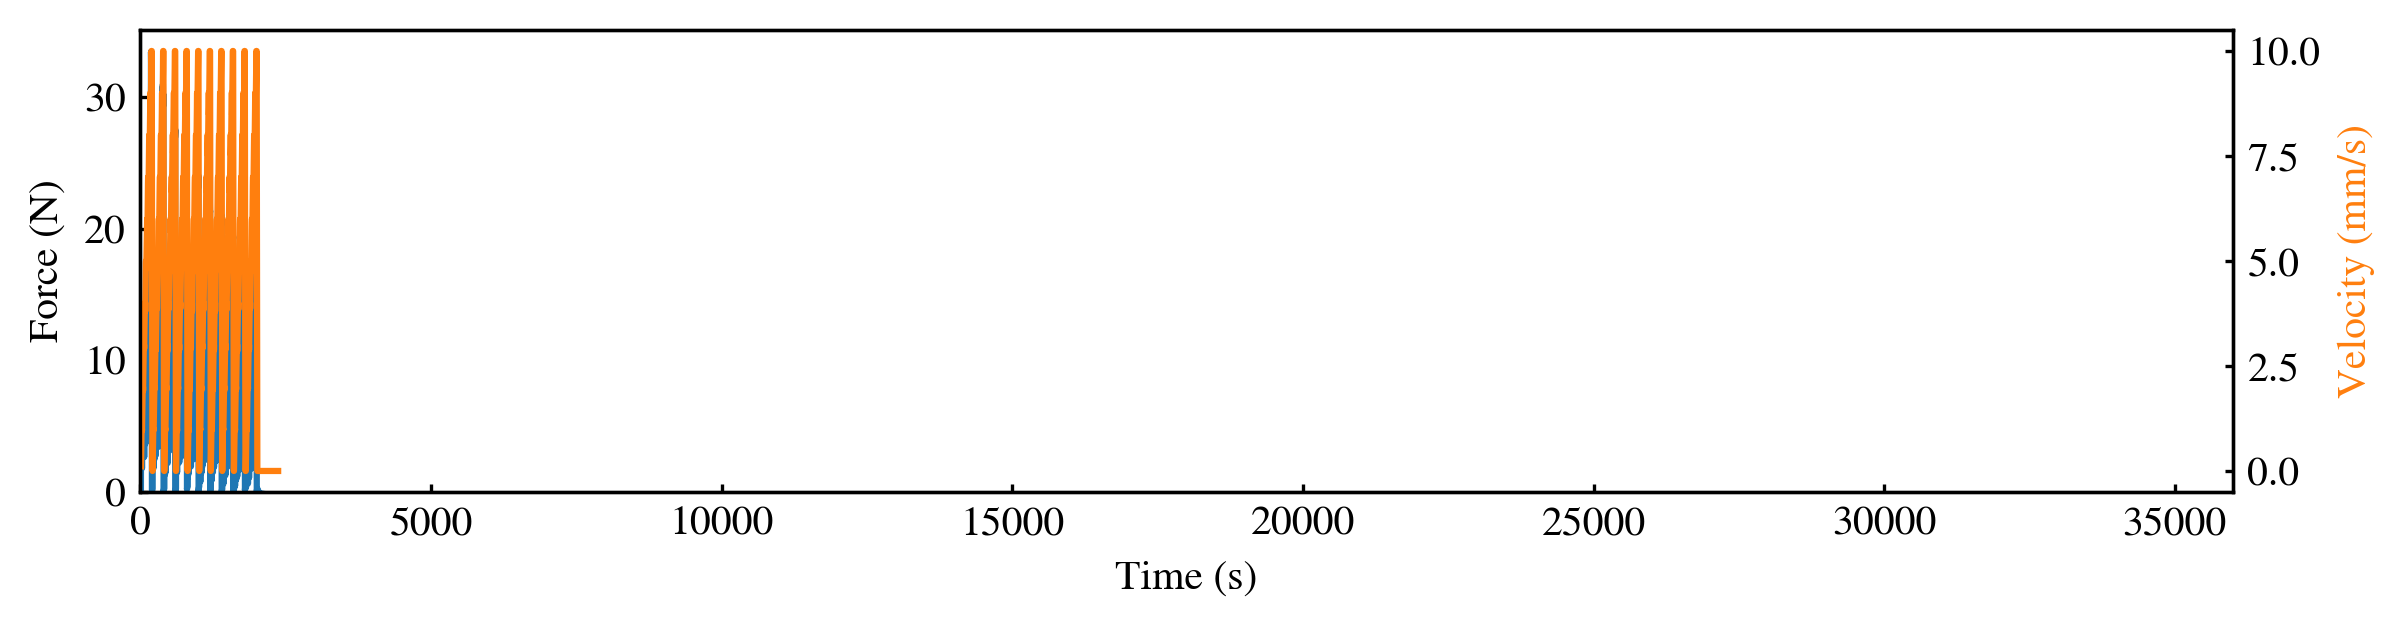

In [103]:
t = data.time_s - data.time_s.min()
force = data.extrusion_force_N
velocity = data.feedrate_mms
plt.figure(figsize=(9, 2), dpi=300)
plt.plot(t, force)
plt.xlim(0, t.max())
plt.ylim(0, force.max() * 1.05)
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
ax = plt.gca()
ax1 = ax.twinx()
ax1.plot(t, velocity.rolling(100).mean(), color="C1")
ax1.set_ylabel("Velocity (mm/s)", color="C1")
ax.set_xlim(0, 36000)

In [104]:
# clean data

# remove tiny force entries
force_min = 0.5 # N
data_clean = data.loc[data.extrusion_force_N >= force_min]

# time start at 0
data_clean.loc[:, "time_s"] -= data_clean.time_s.min()

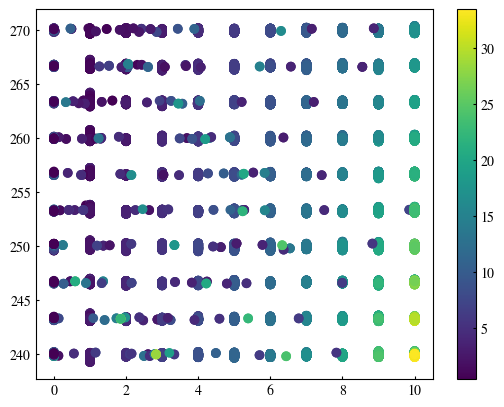

In [105]:
plt.scatter(data_clean.feedrate_mms, data_clean.hotend_temperature_C, c=data_clean.extrusion_force_N)
plt.colorbar()

## 2 Separate based on extruder velocity and temperature

In the data, although we set temperature and velocity to be constant within each step, the actual velocity and temperature are varying with a small noise. This makes it difficult to separate different extrusion conditions by `groupby` directly. Hence, we employ a rolling mean method to smooth out the noise, and use `cumsum()` to define a `step_id`.

In [106]:
step_length = 200
velocity_step = .8

####
window = step_length // 10
min_length = step_length // 10
threshold = velocity_step / 10
diff_length = step_length // 10

####
data_clean.loc[:, "smooth_feedrate"] = data_clean["feedrate_mms"].rolling(window).mean().values
data_clean.loc[:, "gradient"] = data_clean["smooth_feedrate"].diff(diff_length).abs()
data_clean.loc[:, "is_flat"] = data_clean["gradient"].lt(threshold)
data_clean.loc[:, "step_id"] = (~data_clean["is_flat"]).cumsum()

cleaned_steps = []
for step, g_step in data_clean.groupby("step_id"):
    if len(g_step) > min_length:
        cleaned_steps.append(g_step)

C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\3257511942.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "smooth_feedrate"] = data_clean["feedrate_mms"].rolling(window).mean().values
C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\3257511942.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "gradient"] = data_clean["smooth_feedrate"].diff(diff_length).abs()
C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\3257511942.py:13: SettingWithCopyWarning

In [107]:
nGroups = len(cleaned_steps)
print(f"{nGroups} groups ")

100 groups 


In [12]:
def clean_data(raw_data: pd.DataFrame,
               step_length: int = 600,
               velocity_step: float = 0.8,
               feedrate_min: float = 0.2,
               force_min: float = 0.5,
               feedrate_col: str = "feedrate_mms"):
    """
    Parameters
    ----------
    raw_data : pd.DataFrame
        the original table generated by HEPiC
    step_length : int
        the number of rows of data at each setting. This is used to infer the smoothing window size. 
    velocity_step : float
        the interval between adjacent velocity step (in mm/s). This is used to infer the threshold for the velocity gradient. If gradient is greater than the threshold, a new step is recognized.
    feedrate_min : float
        minimum feedrate. This is used to filter the data entries where no extrusion is happening.
    force_min : float
        minimum extrusion force. This is used to filter the data entries where the extrusion force is extremely small. 

    Returns
    -------
    cleaned_steps : list
        a list of pd.DataFrame, each of which is regarded as a single parameter set. 
    data_clean : pd.DataFrame
        the cleaned data table.

    Examples
    --------
    >>> cleaned_steps, data_clean = clean_data(data)
    """

    # remove tiny force entries
    force_min = 0.5 # N
    data_clean = raw_data.loc[(raw_data.extrusion_force_N >= force_min)&(raw_data[feedrate_col]>feedrate_min)]

    # time start at 0
    data_clean.loc[:, "time_s"] -= data_clean.time_s.min()

    window = step_length // 10
    min_length = step_length // 10
    threshold = velocity_step / 10
    diff_length = step_length // 10

    ####
    data_clean.loc[:, "smooth_feedrate"] = data_clean.loc[:, feedrate_col].rolling(window).mean().values
    data_clean.loc[:, "gradient"] = data_clean["smooth_feedrate"].diff(diff_length).abs()
    data_clean.loc[:, "is_flat"] = data_clean["gradient"].lt(threshold)
    data_clean.loc[:, "step_id"] = (~data_clean["is_flat"]).cumsum()

    cleaned_steps = []
    for step, g_step in data_clean.groupby("step_id"):
        if len(g_step) > min_length:
            cleaned_steps.append(g_step)
    
    print(f"number of steps: {len(cleaned_steps)}")

    return cleaned_steps, data_clean

In [6]:
cleaned_steps, data_clean = clean_data(data)

number of steps: 225


C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "smooth_feedrate"] = data_clean.loc[:, "feedrate_mms"].rolling(window).mean().values
C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "gradient"] = data_clean["smooth_feedrate"].diff(diff_length).abs()
C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:41: SettingWithCopy

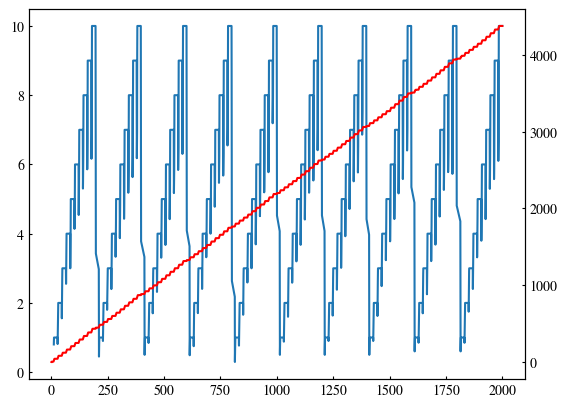

In [108]:
data_part = data_clean.loc[data_clean.time_s < 2000]
plt.plot(data_part.time_s, data_part.smooth_feedrate)
ax = plt.gca()
ax1 = ax.twinx()
ax1.plot(data_part.time_s, data_part.step_id, color="r")
# ax.set_xlim(0, 2000)
# ax1.set_ylim(0, 1000)

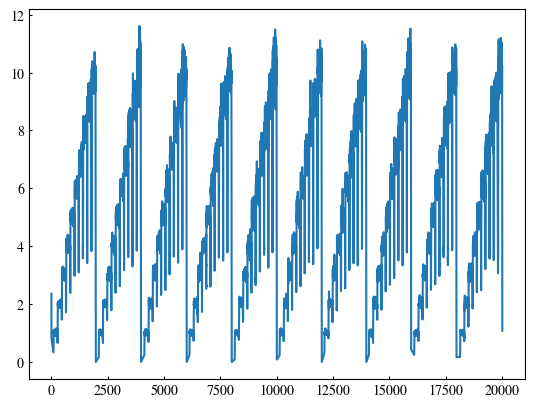

In [109]:
plt.plot(data_clean.measured_feedrate_mms)

In [110]:
Ts, Vs, Fs, DTs, DDs, FEs = [], [], [], [], [], []
for df in cleaned_steps:
    T = df.hotend_temperature_C.mean()
    V = df.feedrate_mms.mean()
    F = df.extrusion_force_N.mean()
    DT = df.die_temperature_C.mean()
    DD = df.die_diameter_px.mean()
    FE = df.measured_feedrate_mms.mean() / V
    Ts.append(T)
    Vs.append(V)
    Fs.append(F)
    DTs.append(DT)
    DDs.append(DD)
    FEs.append(FE)
results = pd.DataFrame({"T": Ts, "V": Vs, "F": Fs, "DT": DTs, "DD": DDs, "FE": FEs})

In [111]:
x = results["V"]
y = results["T"]
z = results["F"]
z1 = results["DT"]
z2 = results["DD"]
z3 = results["FE"]
# z2[z2>50] = 50
z3[z3>1] = 1
# 2. 定义要插值的网格 (即生成的二维图像的分辨率)
# complex number 100j means 100 points inclusive
grid_x, grid_y = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]

# 3. 执行插值
# method 可选: 'linear' (线性), 'nearest' (最近邻), 'cubic' (三次样条)
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
grid_z1 = griddata((x, y), z1, (grid_x, grid_y), method='cubic')
grid_z2 = griddata((x, y), z2, (grid_x, grid_y), method='cubic')
grid_z3 = griddata((x, y), z3, (grid_x, grid_y), method='cubic')

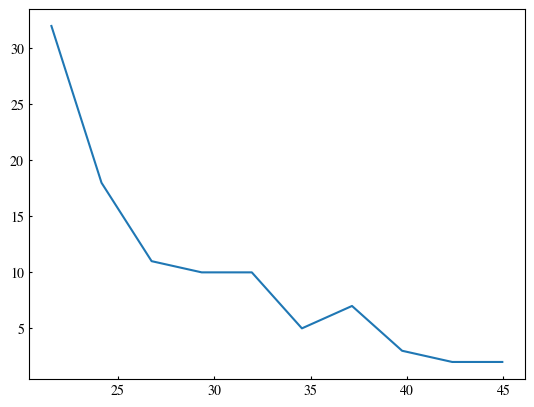

In [112]:
hist, bin_edges = np.histogram(z2)
plt.plot(bin_edges[:-1], hist)

Text(0.01, 0.95, 'feed efficiency')

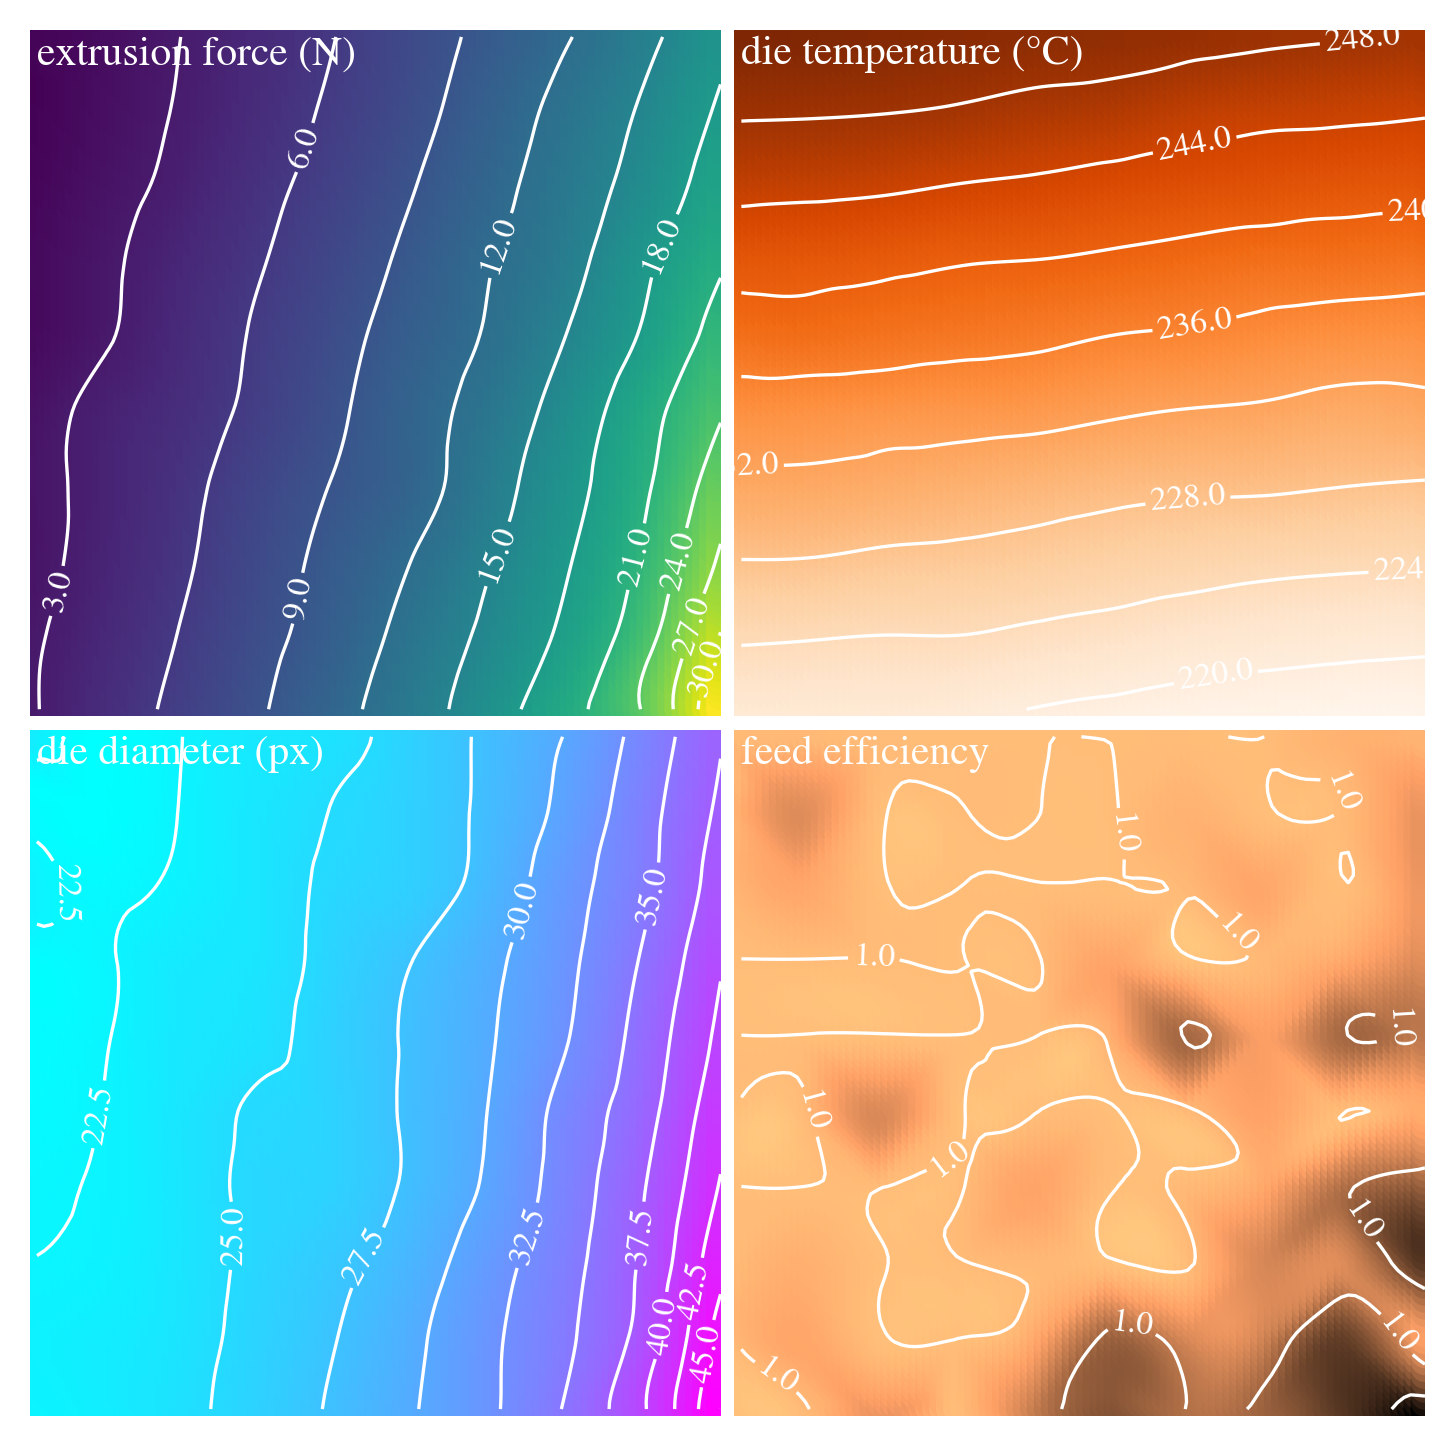

In [114]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=300, gridspec_kw={"wspace":0.02, "hspace":0.02})
ax[0][0].scatter(grid_x, grid_y, c=grid_z)
contour_lines = ax[0][0].contour(grid_x, grid_y, grid_z, levels=10, colors='white', linewidths=0.8)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.1f')
ax[0][0].axis("off")
ax[0][0].annotate("extrusion force (N)", xy=(0.01, 0.95), xycoords="axes fraction", color="white", ha="left")

ax[0][1].scatter(grid_x, grid_y, c=grid_z1, cmap="Oranges")
contour_lines = ax[0][1].contour(grid_x, grid_y, grid_z1, levels=10, colors='white', linewidths=0.8)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.1f')
ax[0][1].axis("off")
ax[0][1].annotate("die temperature (°C)", xy=(0.01, 0.95), xycoords="axes fraction", color="white", ha="left")

ax[1][0].scatter(grid_x, grid_y, c=grid_z2, cmap="cool")
contour_lines = ax[1][0].contour(grid_x, grid_y, grid_z2, vmin=20, vmax=50, levels=10, colors='white', linewidths=0.8 )
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.1f')
ax[1][0].axis("off")
ax[1][0].annotate("die diameter (px)", xy=(0.01, 0.95), xycoords="axes fraction", color="white", ha="left")

ax[1][1].scatter(grid_x, grid_y, c=grid_z3, cmap="copper")
contour_lines = ax[1][1].contour(grid_x, grid_y, grid_z3, levels=2, colors='white', linewidths=0.8)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.1f')
ax[1][1].axis("off")
ax[1][1].annotate("feed efficiency", xy=(0.01, 0.95), xycoords="axes fraction", color="white", ha="left")

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2294765568.py:6: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel("Hotend temperature, $T$ ($^\circ$C)")


Text(0, 0.5, 'Hotend temperature, $T$ ($^\\circ$C)')

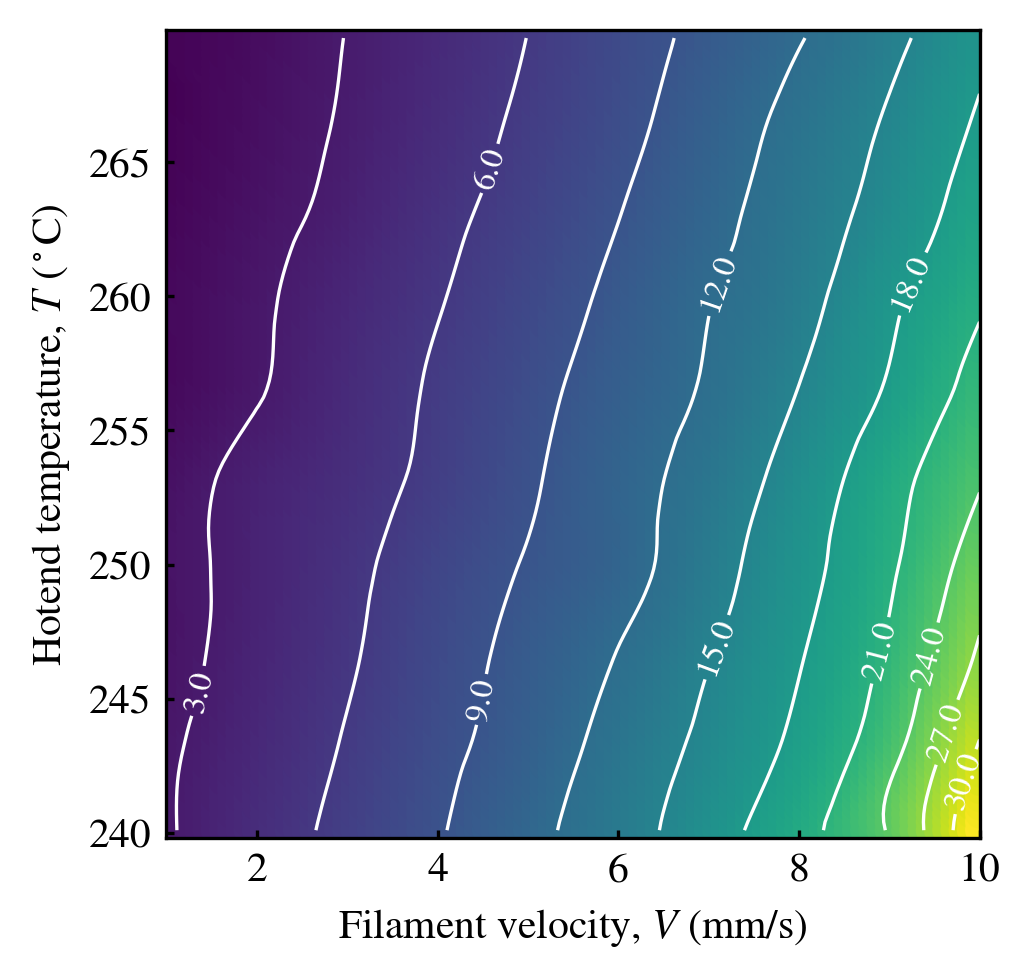

In [137]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=300, gridspec_kw={"wspace":0.02, "hspace":0.02})
ax.scatter(grid_x, grid_y, c=grid_z)
contour_lines = ax.contour(grid_x, grid_y, grid_z, levels=10, colors='white', linewidths=0.8)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.1f')
ax.set_xlabel("Filament velocity, $V$ (mm/s)")
ax.set_ylabel("Hotend temperature, $T$ ($^\circ$C)")

## 3 Reproducibility

In [118]:
data_folder = google_drive_base / "Polymaker" / "003.挤出过程研究" / "003.挤出测试平台" / "实验数据" / "002.挤出力数据" / "PETG" / "PETG651"
filename = "20251202_084235_autosave.csv"
data = pd.read_csv(data_folder / filename)
filename1 = "20251201_122824_autosave.csv"
data1 = pd.read_csv(data_folder / filename1)
data_folder = google_drive_base / "Polymaker" / "003.挤出过程研究" / "003.挤出测试平台" / "实验数据" / "002.挤出力数据" / "PETG" / "G235-大理石"
filename2 = "20251205_111201_autosave.csv"
data2 = pd.read_csv(data_folder / filename2)

In [119]:
cleaned_steps, data_clean = clean_data(data)
cleaned_steps1, data_clean1 = clean_data(data1)
cleaned_steps2, data_clean2 = clean_data(data2)

C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "smooth_feedrate"] = data_clean.loc[:, "feedrate_mms"].rolling(window).mean().values
C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "gradient"] = data_clean["smooth_feedrate"].diff(diff_length).abs()
C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:41: SettingWithCopy

number of steps: 225
number of steps: 225


C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "smooth_feedrate"] = data_clean.loc[:, "feedrate_mms"].rolling(window).mean().values
C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "gradient"] = data_clean["smooth_feedrate"].diff(diff_length).abs()
C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:41: SettingWithCopy

number of steps: 99


In [125]:
vels, forces, forces_std = [], [], []
for step in cleaned_steps:
    temp = step["hotend_temperature_C"].mean()
    vel = step["feedrate_mms"].mean()
    force_mean = step["extrusion_force_N"].mean()
    force_std = step["extrusion_force_N"].std()
    if temp > 254 and temp < 256:
        vels.append(vel)
        forces.append(force_mean)
        forces_std.append(force_std)

vels1, forces1, forces_std1 = [], [], []
for step in cleaned_steps1:
    temp = step["hotend_temperature_C"].mean()
    vel = step["feedrate_mms"].mean()
    force_mean = step["extrusion_force_N"].mean()
    force_std = step["extrusion_force_N"].std()
    if temp > 254 and temp < 256:
        vels1.append(vel)
        forces1.append(force_mean)
        forces_std1.append(force_std)

vels2, forces2, forces_std2 = [], [], []
for step in cleaned_steps2:
    temp = step["hotend_temperature_C"].mean()
    vel = step["feedrate_mms"].mean()
    force_mean = step["extrusion_force_N"].mean()
    force_std = step["extrusion_force_N"].std()
    print(temp)
    if temp > 254 and temp < 257:
        vels2.append(vel)
        forces2.append(force_mean)
        forces_std2.append(force_std)

239.96012195121946
239.93507462686563
239.92895522388062
239.9965671641791
240.03569230769233
239.93830769230772
239.9856923076923
239.9922727272727
239.90640625000003
239.995
243.23298701298705
243.27153846153828
243.3067647058823
243.28761194029852
243.37015151515152
243.2507692307692
243.34718750000002
243.29531250000002
243.30374999999998
246.63430379746836
246.6876470588235
246.6273134328358
246.66215384615387
246.59338461538462
246.6087692307692
246.6375384615385
246.63703125
246.61640624999998
246.65384615384613
249.92746478873238
249.96911764705885
249.9798484848485
250.0056923076923
249.98075757575762
249.95156250000002
249.94727272727275
249.97015384615386
249.974375
250.01859374999998
253.30012048192776
253.2876119402984
253.30764705882345
253.2520967741936
253.3350769230769
253.34234375
253.31046153846154
253.24734375000003
253.33923076923082
253.26499999999993
256.55543209876544
256.6229850746269
256.65107692307686
256.59731343283585
256.61046875
256.59749999999997
256.662

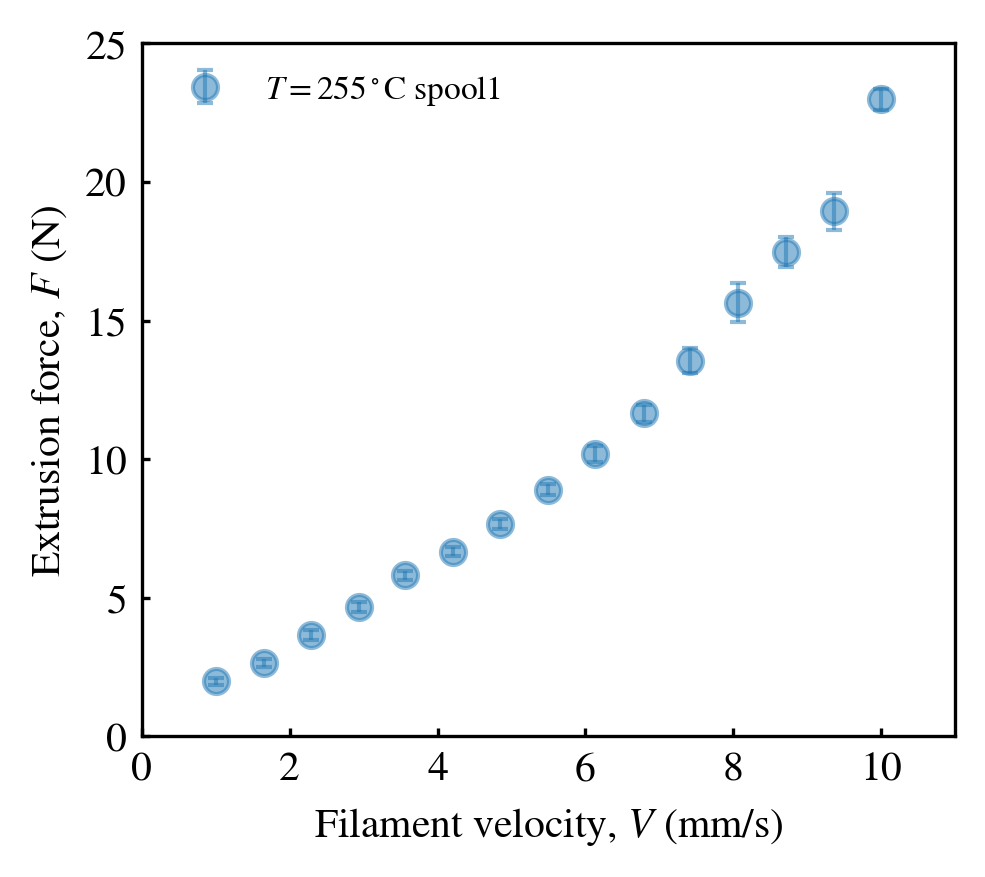

In [130]:
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
ax.errorbar(vels, forces, yerr=forces_std, marker="o", ls="", lw=1, capsize=2, label="$T=255^\\circ$C spool1", alpha=0.5)
# ax.errorbar(vels1, forces1, yerr=forces_std1, marker="o", ls="", lw=1, capsize=2, label="$T=255^\\circ$C spool2", color=bestcolor(2), alpha=0.5)
# ax.errorbar(vels2, forces2, yerr=forces_std2, marker="x", ls="", lw=1, capsize=2, label="$T=255^\\circ$C test-marble", color=bestcolor(3))
ax.set_xlim(0, 11)
ax.set_ylim(0, 25)
ax.set_xlabel("Filament velocity, $V$ (mm/s)")
ax.set_ylabel("Extrusion force, $F$ (N)")
ax.legend(fontsize=8, frameon=False)

## 4 Towards steady state: low and high velocity

In [138]:
data_folder = google_drive_base / "Polymaker" / "003.挤出过程研究" / "003.挤出测试平台" / "实验数据" / "002.挤出力数据" / "PETG" / "PETG651"
filename = "20251202_084235_autosave.csv"
data = pd.read_csv(data_folder / filename)

In [140]:
cleaned_steps, data_clean = clean_data(data)

number of steps: 225


C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "smooth_feedrate"] = data_clean.loc[:, "feedrate_mms"].rolling(window).mean().values
C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "gradient"] = data_clean["smooth_feedrate"].diff(diff_length).abs()
C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2610815251.py:41: SettingWithCopy

In [162]:
df1 = data_clean.iloc[1050:1250]

C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\2858261372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["time_s"] -= df1["time_s"].min()


(0.0, 10.0)

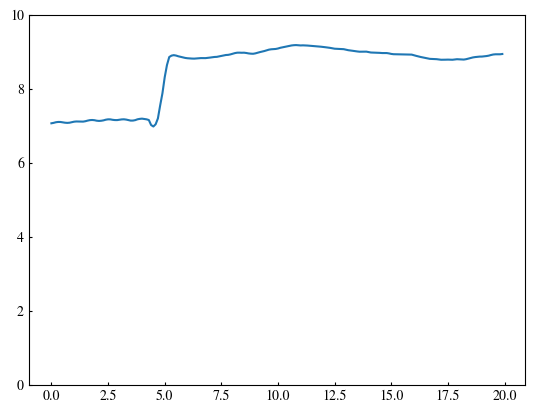

In [165]:
df1["time_s"] -= df1["time_s"].min()
plt.plot(df1["time_s"], df1["extrusion_force_N"])
plt.ylim(0, 10)

C:\Users\zhengyang\AppData\Local\Temp\ipykernel_24912\221520915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["time_s"] -= df2["time_s"].min()


(0.0, 40.0)

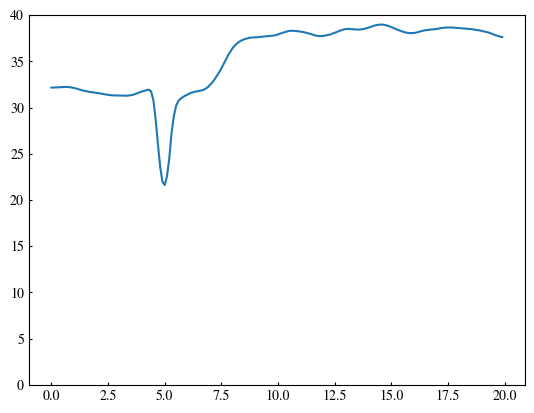

In [164]:
df2 = data_clean[6000:6200]
df2["time_s"] -= df2["time_s"].min()
plt.plot(df2["time_s"], df2["extrusion_force_N"])
plt.ylim(0, 40)

Text(0.5, 0, 'Time (s)')

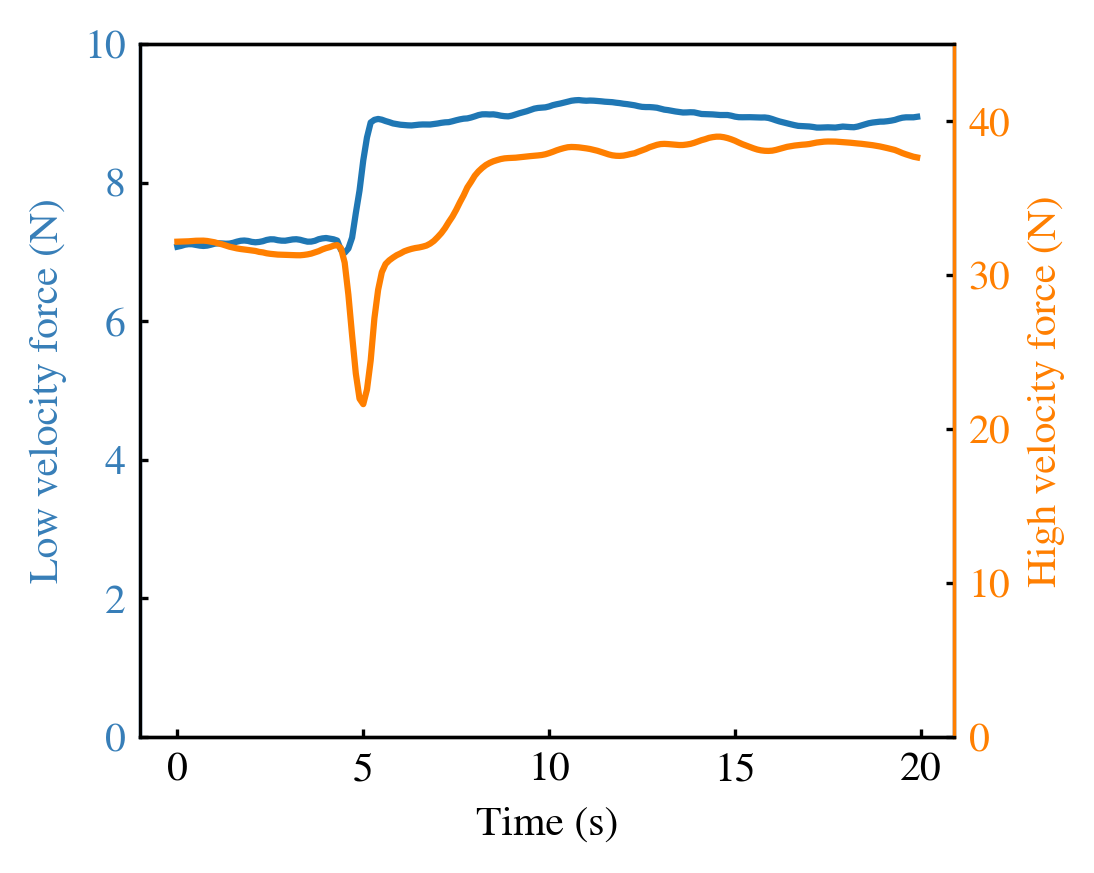

In [179]:
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
ax.plot(df1["time_s"], df1["extrusion_force_N"])
ax.set_ylim(0, 10)
ax.set_ylabel("Low velocity force (N)", color=bestcolor(0))
ax.tick_params(axis='y', labelcolor=bestcolor(0))
ax.spines['left'].set_color(bestcolor(0))
ax1 = ax.twinx()
ax1.plot(df2["time_s"], df2["extrusion_force_N"], color=bestcolor(1))
ax1.set_ylabel("High velocity force (N)", color=bestcolor(1))
ax1.tick_params(axis='y', labelcolor=bestcolor(1))
ax1.spines['right'].set_color(bestcolor(1))
ax1.set_ylim(0, 45)
ax.set_xlabel("Time (s)")

## 5 E3D hotend and samples

### 5.1 PolySonic @ BBL A1 hotend

In [93]:
folder = Path(r"C:\Users\zhengyang\OneDrive - 苏州聚复科技股份有限公司\工作文件\003.挤出过程研究\003.挤出测试平台\实验数据\003.散装数据\2025-12-19")
filename3 = "20251219_112842_autosave-3.csv"
filename4 = "20251219_123732_autosave-4.csv"
data3 = pd.read_csv(folder / filename3)
data4 = pd.read_csv(folder / filename4)

In [94]:
cleaned_steps3, data_clean = clean_data(data3, step_length=300)
cleaned_steps4, data_clean = clean_data(data4, step_length=300)

number of steps: 60
number of steps: 60


c:\Users\zhengyang\Documents\GitHub\ETP\Code\utils.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "smooth_feedrate"] = data_clean.loc[:, feedrate_col].rolling(window).mean().values
c:\Users\zhengyang\Documents\GitHub\ETP\Code\utils.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "gradient"] = data_clean["smooth_feedrate"].diff(diff_length).abs()
c:\Users\zhengyang\Documents\GitHub\ETP\Code\utils.py:155: SettingWithCopyWarning: 
A value is trying to be set on 

In [95]:
vels, forces, forces_std = [], [], []
Ts = [210, 220, 230]
Trange = 2
organized_data3 = {}
for T in Ts:
    organized_data3[T] = {"vels":[], "forces":[], "forces_std":[], "dieswell": [], "dieswell_std": [], "dietemp": [], "dietemp_std": []}

for step in cleaned_steps3:
    temp = step["hotend_temperature_C"].mean()
    vel = step["feedrate_mms"].mean()
    force_mean = step["extrusion_force_N"].mean()
    force_std = step["extrusion_force_N"].std()
    dieswell_mean = step["die_diameter_px"].mean()
    dieswell_std = step["die_diameter_px"].std()
    dietemp_mean = step["die_temperature_C"].mean()
    dietemp_std = step["die_temperature_C"].std()
    for T in Ts:
        if temp > T-Trange and temp < T+Trange:
            organized_data3[T]["vels"].append(vel)
            organized_data3[T]["forces"].append(force_mean)
            organized_data3[T]["forces_std"].append(force_std)
            organized_data3[T]["dieswell"].append(dieswell_mean)
            organized_data3[T]["dieswell_std"].append(dieswell_std)
            organized_data3[T]["dietemp"].append(dietemp_mean)
            organized_data3[T]["dietemp_std"].append(dietemp_std)

In [96]:
Ts = [210, 220, 230]
Trange = 2
organized_data4 = {}
for T in Ts:
    organized_data4[T] = {"vels":[], "forces":[], "forces_std":[], "dieswell": [], "dieswell_std": [], "dietemp": [], "dietemp_std": []}

for step in cleaned_steps4:
    temp = step["hotend_temperature_C"].mean()
    vel = step["feedrate_mms"].mean()
    force_mean = step["extrusion_force_N"].mean()
    force_std = step["extrusion_force_N"].std()
    dieswell_mean = step["die_diameter_px"].mean()
    dieswell_std = step["die_diameter_px"].std()
    dietemp_mean = step["die_temperature_C"].mean()
    dietemp_std = step["die_temperature_C"].std()
    for T in Ts:
        if temp > T-Trange and temp < T+Trange:
            organized_data4[T]["vels"].append(vel)
            organized_data4[T]["forces"].append(force_mean)
            organized_data4[T]["forces_std"].append(force_std)
            organized_data4[T]["dieswell"].append(dieswell_mean)
            organized_data4[T]["dieswell_std"].append(dieswell_std)
            organized_data4[T]["dietemp"].append(dietemp_mean)
            organized_data4[T]["dietemp_std"].append(dietemp_std)

Text(0, 0.5, 'Extrusion force, $F$ (N)')

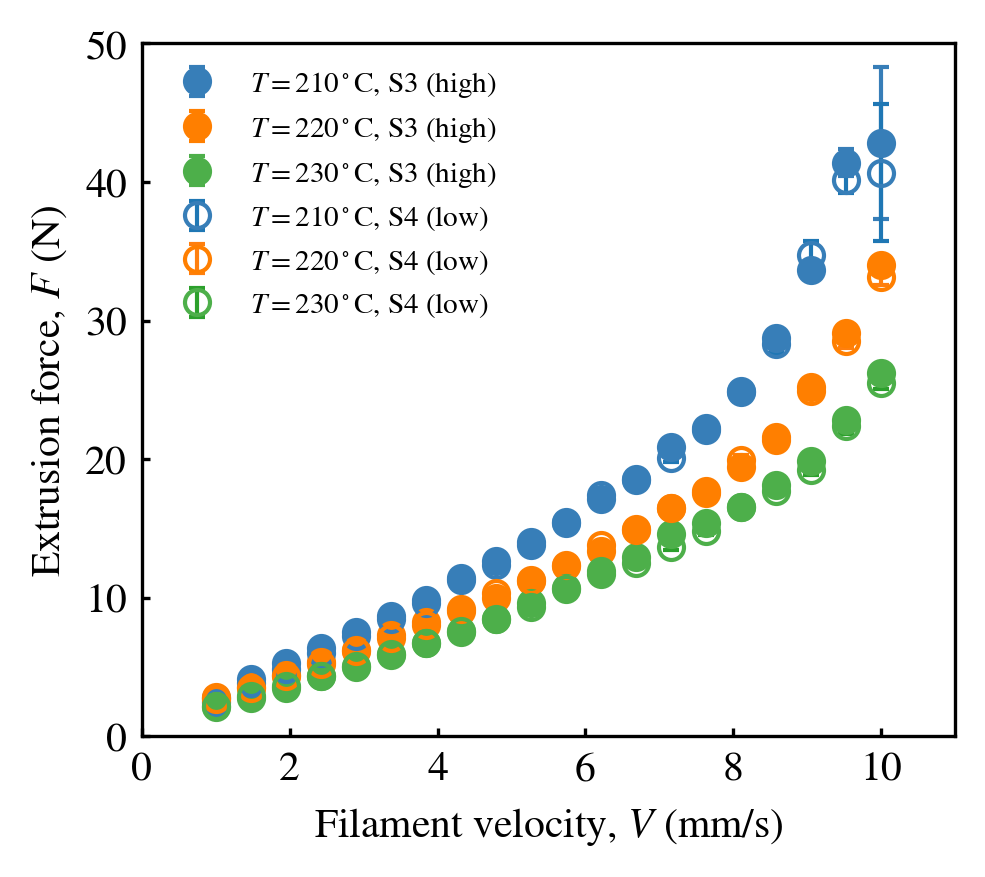

In [81]:
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
for i, T in enumerate(organized_data3.keys()):
    vels = organized_data3[T]["vels"]
    forces = organized_data3[T]["forces"]
    forces_std = organized_data3[T]["forces_std"]   
    ax.errorbar(vels, forces, yerr=forces_std, marker="o", ls="", lw=1, capsize=2, color=bestcolor(i), label=f"$T={T}^\\circ$C, S3 (high)")

for i, T in enumerate(organized_data4.keys()):
    vels = organized_data4[T]["vels"]
    forces = organized_data4[T]["forces"]
    forces_std = organized_data4[T]["forces_std"]   
    ax.errorbar(vels, forces, yerr=forces_std, marker="o", ls="", lw=1, capsize=2, mfc=(0,0,0,0), mec=bestcolor(i), label=f"$T={T}^\\circ$C, S4 (low)")
ax.legend(fontsize=7, frameon=False)
ax.set_xlim(0, 11)
ax.set_ylim(0, 50)
ax.set_xlabel("Filament velocity, $V$ (mm/s)")
ax.set_ylabel("Extrusion force, $F$ (N)")

Text(0, 0.5, 'Die diameter, $D$ (px)')

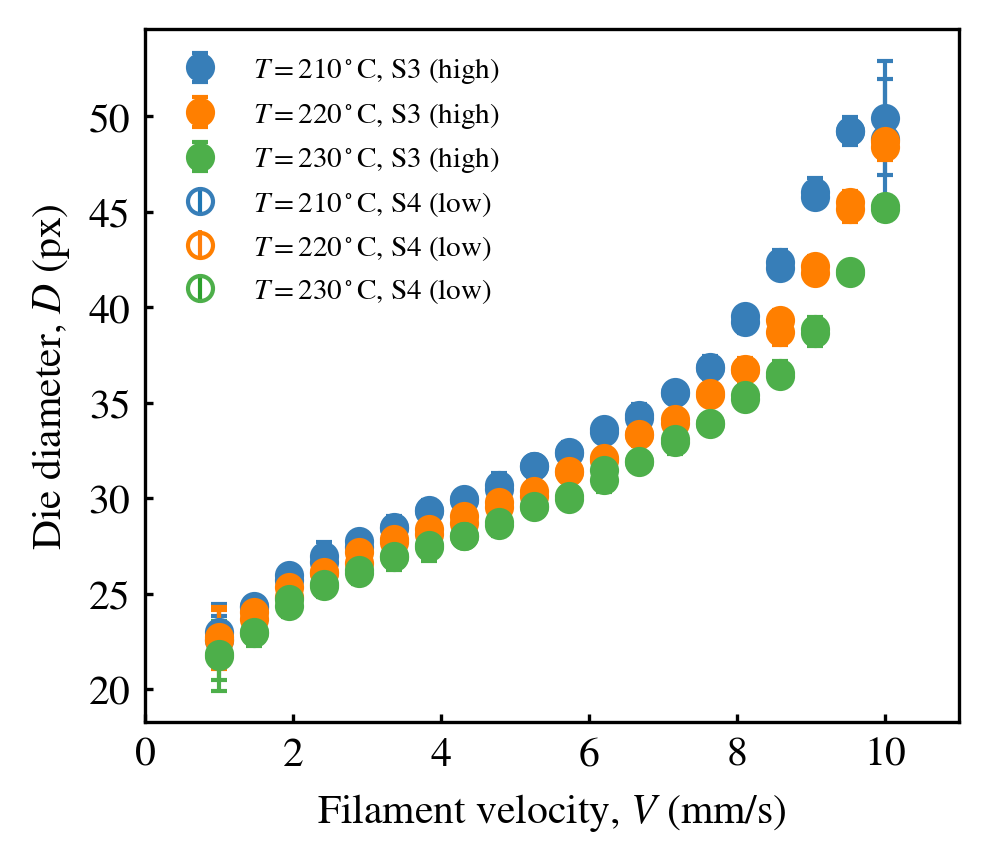

In [71]:
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
for i, T in enumerate(organized_data3.keys()):
    vels = organized_data3[T]["vels"]
    forces = organized_data3[T]["dieswell"]
    forces_std = organized_data3[T]["dieswell_std"]   
    ax.errorbar(vels, forces, yerr=forces_std, marker="o", ls="", lw=1, capsize=2, color=bestcolor(i), label=f"$T={T}^\\circ$C, S3 (high)")

for i, T in enumerate(organized_data4.keys()):
    vels = organized_data4[T]["vels"]
    forces = organized_data4[T]["dieswell"]
    forces_std = organized_data4[T]["dieswell_std"]   
    ax.errorbar(vels, forces, yerr=forces_std, marker="o", ls="", lw=1, capsize=2, mfc=(0,0,0,0), mec=bestcolor(i), label=f"$T={T}^\\circ$C, S4 (low)")
ax.legend(fontsize=7, frameon=False)
ax.set_xlim(0, 11)
# ax.set_ylim(0, 60)
ax.set_xlabel("Filament velocity, $V$ (mm/s)")
ax.set_ylabel("Die diameter, $D$ (px)")

### 5.2 PolySonic @ E3D FUGE hotend

In [89]:
folder = Path(r"C:\Users\zhengyang\OneDrive - 苏州聚复科技股份有限公司\工作文件\003.挤出过程研究\003.挤出测试平台\实验数据\003.散装数据\2025-12-22")
filename3 = "20251222_112125_autosave-3.csv"
filename4 = "20251222_121026_autosave-4.csv"
data3 = pd.read_csv(folder / filename3)
data4 = pd.read_csv(folder / filename4)

In [90]:
cleaned_steps3, data_clean = clean_data(data3, step_length=200)
cleaned_steps4, data_clean = clean_data(data4, step_length=200)

number of steps: 60
number of steps: 60


c:\Users\zhengyang\Documents\GitHub\ETP\Code\utils.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "smooth_feedrate"] = data_clean.loc[:, feedrate_col].rolling(window).mean().values
c:\Users\zhengyang\Documents\GitHub\ETP\Code\utils.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "gradient"] = data_clean["smooth_feedrate"].diff(diff_length).abs()
c:\Users\zhengyang\Documents\GitHub\ETP\Code\utils.py:155: SettingWithCopyWarning: 
A value is trying to be set on 

In [91]:
vels, forces, forces_std = [], [], []
Ts = [210, 220, 230]
Trange = 2
organized_data3_fuge = {}
for T in Ts:
    organized_data3_fuge[T] = {"vels":[], "forces":[], "forces_std":[], "dieswell": [], "dieswell_std": [], "dietemp": [], "dietemp_std": []}

for step in cleaned_steps3:
    temp = step["hotend_temperature_C"].mean()
    vel = step["feedrate_mms"].mean()
    force_mean = step["extrusion_force_N"].mean()
    force_std = step["extrusion_force_N"].std()
    dieswell_mean = step["die_diameter_px"].mean()
    dieswell_std = step["die_diameter_px"].std()
    dietemp_mean = step["die_temperature_C"].mean()
    dietemp_std = step["die_temperature_C"].std()
    for T in Ts:
        if temp > T-Trange and temp < T+Trange:
            organized_data3_fuge[T]["vels"].append(vel)
            organized_data3_fuge[T]["forces"].append(force_mean)
            organized_data3_fuge[T]["forces_std"].append(force_std)
            organized_data3_fuge[T]["dieswell"].append(dieswell_mean)
            organized_data3_fuge[T]["dieswell_std"].append(dieswell_std)
            organized_data3_fuge[T]["dietemp"].append(dietemp_mean)
            organized_data3_fuge[T]["dietemp_std"].append(dietemp_std)

In [92]:
Ts = [210, 220, 230]
Trange = 2
organized_data4_fuge = {}
for T in Ts:
    organized_data4_fuge[T] = {"vels":[], "forces":[], "forces_std":[], "dieswell": [], "dieswell_std": [], "dietemp": [], "dietemp_std": []}

for step in cleaned_steps4:
    temp = step["hotend_temperature_C"].mean()
    vel = step["feedrate_mms"].mean()
    force_mean = step["extrusion_force_N"].mean()
    force_std = step["extrusion_force_N"].std()
    dieswell_mean = step["die_diameter_px"].mean()
    dieswell_std = step["die_diameter_px"].std()
    dietemp_mean = step["die_temperature_C"].mean()
    dietemp_std = step["die_temperature_C"].std()
    for T in Ts:
        if temp > T-Trange and temp < T+Trange:
            organized_data4_fuge[T]["vels"].append(vel)
            organized_data4_fuge[T]["forces"].append(force_mean)
            organized_data4_fuge[T]["forces_std"].append(force_std)
            organized_data4_fuge[T]["dieswell"].append(dieswell_mean)
            organized_data4_fuge[T]["dieswell_std"].append(dieswell_std)
            organized_data4_fuge[T]["dietemp"].append(dietemp_mean)
            organized_data4_fuge[T]["dietemp_std"].append(dietemp_std)

Text(0, 0.5, 'Extrusion force, $F$ (N)')

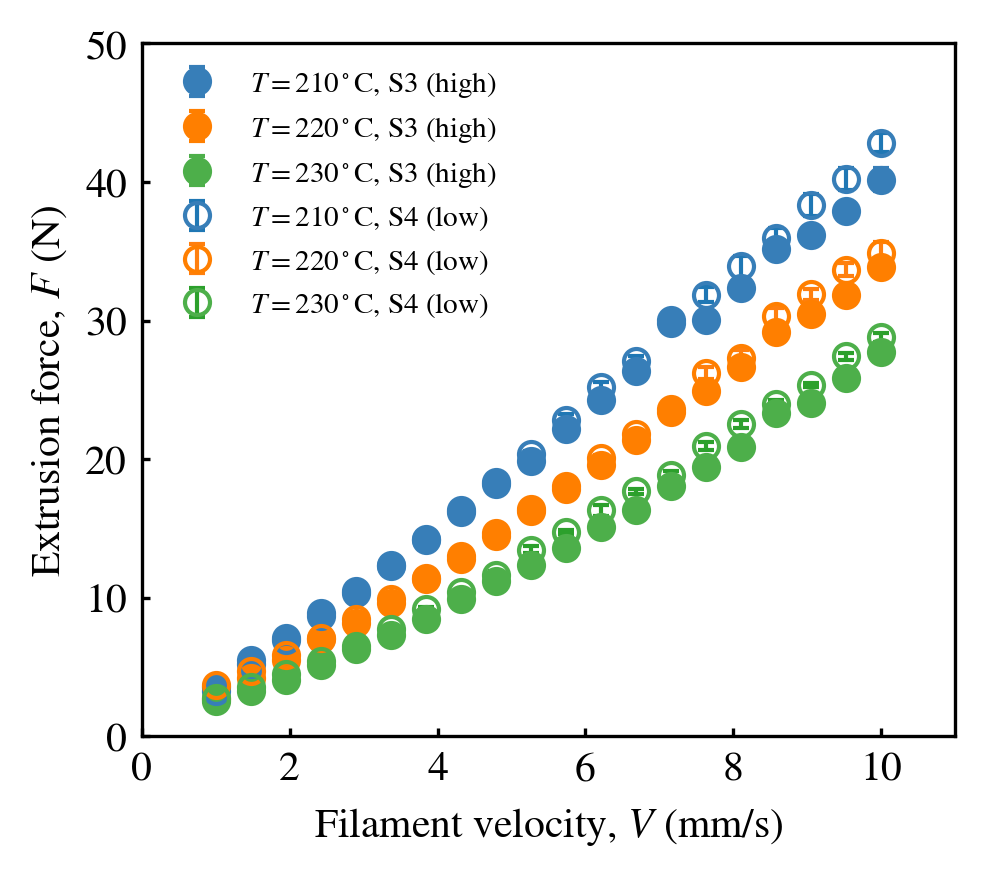

In [60]:
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
for i, T in enumerate(organized_data3_fuge.keys()):
    vels = organized_data3_fuge[T]["vels"]
    forces = organized_data3_fuge[T]["forces"]
    forces_std = organized_data3_fuge[T]["forces_std"]   
    ax.errorbar(vels, forces, yerr=forces_std, marker="o", ls="", lw=1, capsize=2, color=bestcolor(i), label=f"$T={T}^\\circ$C, S3 (high)")

for i, T in enumerate(organized_data4_fuge.keys()):
    vels = organized_data4_fuge[T]["vels"]
    forces = organized_data4_fuge[T]["forces"]
    forces_std = organized_data4_fuge[T]["forces_std"]   
    ax.errorbar(vels, forces, yerr=forces_std, marker="o", ls="", lw=1, capsize=2, mfc=(0,0,0,0), mec=bestcolor(i), label=f"$T={T}^\\circ$C, S4 (low)")
ax.legend(fontsize=7, frameon=False)
ax.set_xlim(0, 11)
ax.set_ylim(0, 50)
ax.set_xlabel("Filament velocity, $V$ (mm/s)")
ax.set_ylabel("Extrusion force, $F$ (N)")

Text(0, 0.5, 'Die diameter, $D$ (px)')

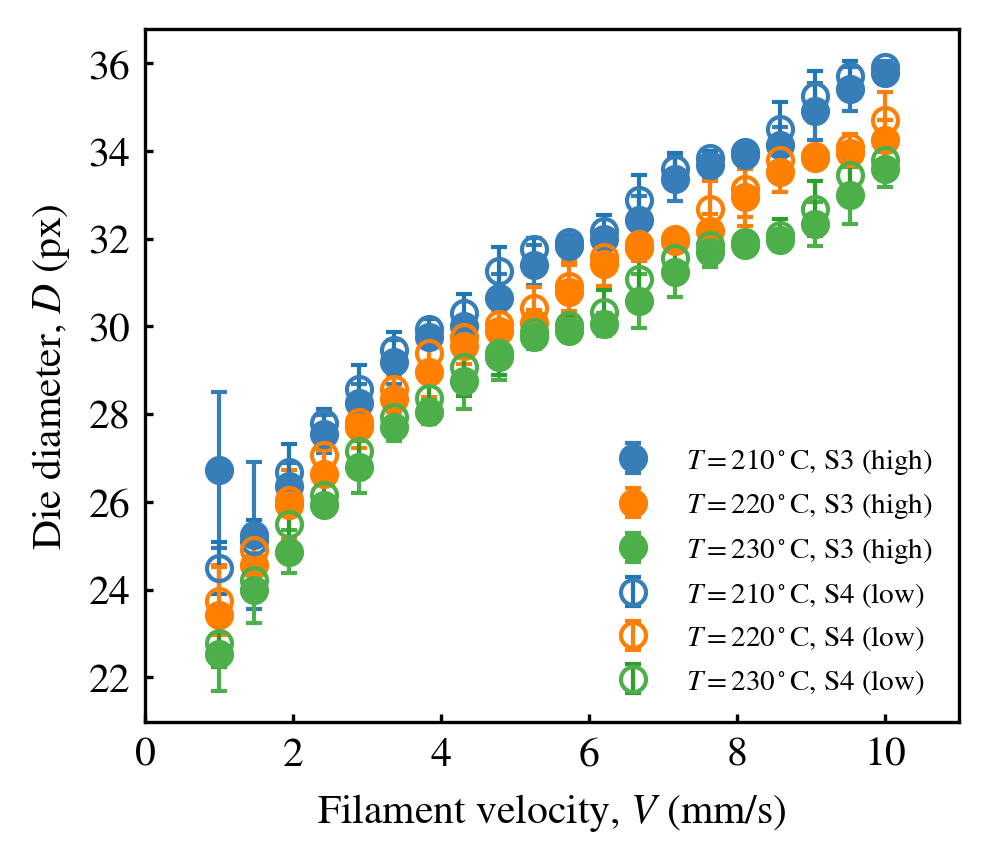

In [59]:
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
for i, T in enumerate(organized_data3_fuge.keys()):
    vels = organized_data3_fuge[T]["vels"]
    forces = organized_data3_fuge[T]["dieswell"]
    forces_std = organized_data3_fuge[T]["dieswell_std"]   
    ax.errorbar(vels, forces, yerr=forces_std, marker="o", ls="", lw=1, capsize=2, color=bestcolor(i), label=f"$T={T}^\\circ$C, S3 (high)")

for i, T in enumerate(organized_data4_fuge.keys()):
    vels = organized_data4_fuge[T]["vels"]
    forces = organized_data4_fuge[T]["dieswell"]
    forces_std = organized_data4_fuge[T]["dieswell_std"]   
    ax.errorbar(vels, forces, yerr=forces_std, marker="o", ls="", lw=1, capsize=2, mfc=(0,0,0,0), mec=bestcolor(i), label=f"$T={T}^\\circ$C, S4 (low)")
ax.legend(fontsize=7, frameon=False)
ax.set_xlim(0, 11)
# ax.set_ylim(0, 60)
ax.set_xlabel("Filament velocity, $V$ (mm/s)")
ax.set_ylabel("Die diameter, $D$ (px)")

### 5.3 Compare FUGE and BBL A1 hotends

Text(0, 0.5, 'Extrusion force, $F$ (N)')

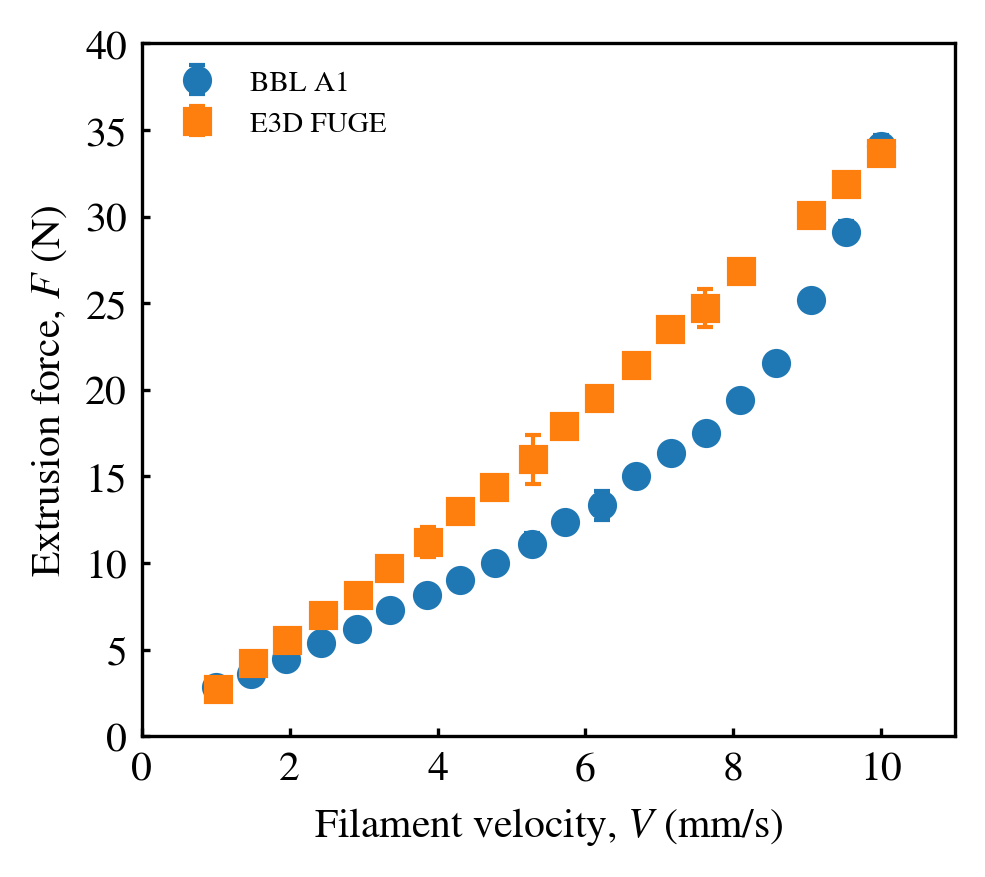

In [23]:
a1 = organized_data3[220]
fuge = organized_data3_fuge[220]

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
ax.errorbar(a1["vels"], a1["forces"], yerr=a1["forces_std"], marker="o", ls="", lw=1, capsize=2, label="BBL A1")
ax.errorbar(fuge["vels"], fuge["forces"], yerr=fuge["forces_std"], marker="s", ls="", lw=1, capsize=2, label="E3D FUGE")
ax.legend(fontsize=7, frameon=False)
ax.set_xlim(0, 11)
ax.set_ylim(0, 40)
ax.set_xlabel("Filament velocity, $V$ (mm/s)")
ax.set_ylabel("Extrusion force, $F$ (N)")

Text(0, 0.5, 'Die diameter, $D$ (px)')

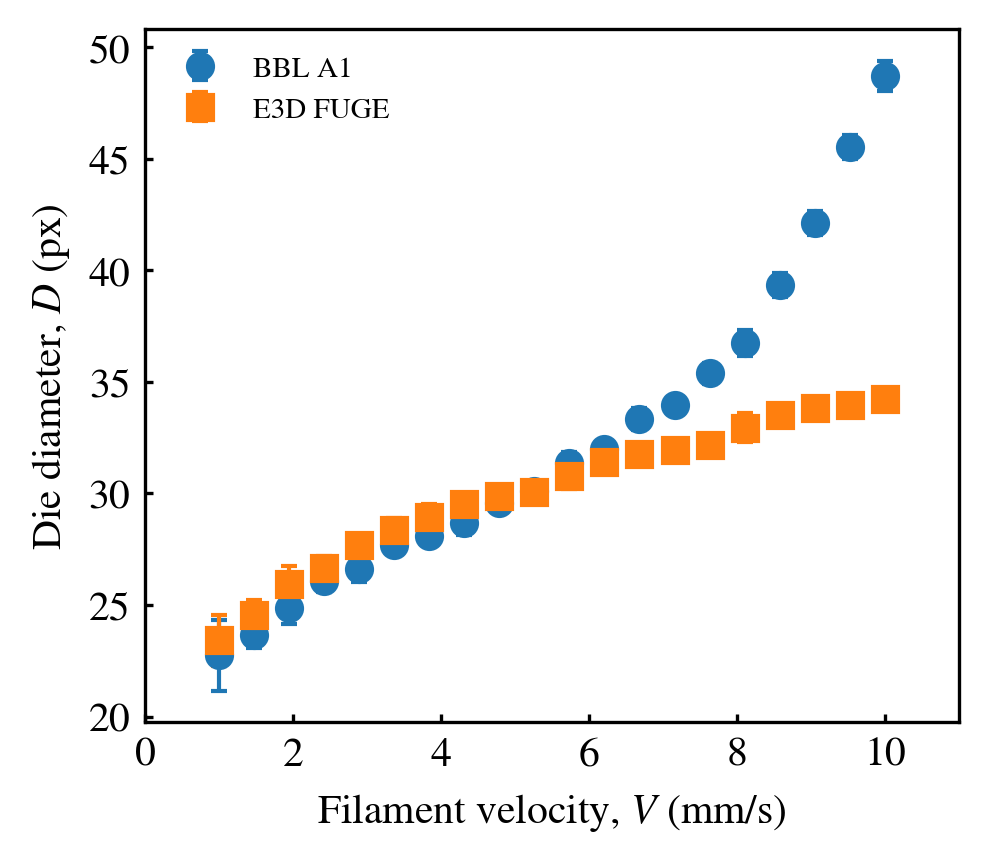

In [86]:
a1 = organized_data3[220]
fuge = organized_data3_fuge[220]

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
ax.errorbar(a1["vels"], a1["dieswell"], yerr=a1["dieswell_std"], marker="o", ls="", lw=1, capsize=2, label="BBL A1")
ax.errorbar(fuge["vels"], fuge["dieswell"], yerr=fuge["dieswell_std"], marker="s", ls="", lw=1, capsize=2, label="E3D FUGE")
ax.legend(fontsize=7, frameon=False)
ax.set_xlim(0, 11)
# ax.set_ylim(0, 40)
ax.set_xlabel("Filament velocity, $V$ (mm/s)")
ax.set_ylabel("Die diameter, $D$ (px)")

Text(0, 0.5, 'Die temperature, $T$ (°C)')

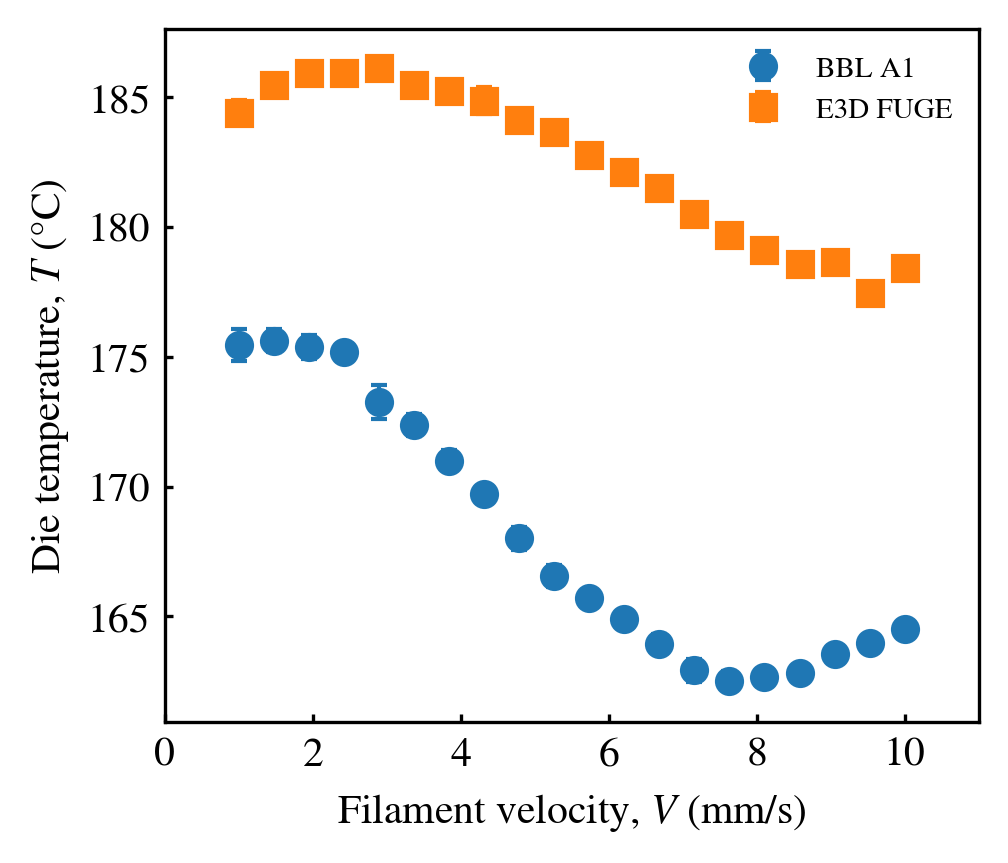

In [98]:
a1 = organized_data3[220]
fuge = organized_data3_fuge[220]

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
ax.errorbar(a1["vels"], a1["dietemp"], yerr=a1["dietemp_std"], marker="o", ls="", lw=1, capsize=2, label="BBL A1")
ax.errorbar(fuge["vels"], fuge["dietemp"], yerr=fuge["dietemp_std"], marker="s", ls="", lw=1, capsize=2, label="E3D FUGE")
ax.legend(fontsize=7, frameon=False)
ax.set_xlim(0, 11)
# ax.set_ylim(0, 40)
ax.set_xlabel("Filament velocity, $V$ (mm/s)")
ax.set_ylabel("Die temperature, $T$ (°C)")

## 6 Force-swell correlation

We noticed that the isotherms of extrusion force and die swell look quite similar, suggesting that these two quantities are highly correlated. In this section, we examine the correlation between them, within the same material and across different materials. 

In [2]:
folder = Path(r"C:\Users\zhengyang\OneDrive - 苏州聚复科技股份有限公司\工作文件\003.挤出过程研究\003.挤出测试平台\实验数据\002.挤出力数据\ABS\PolyLite ABS")
filename = "20251118_112126_autosave.csv"
data = pd.read_csv(folder / filename)

In [4]:
data

,extrusion_force_N,die_temperature_C,die_diameter_px,meter_count_mm,gcode,hotend_temperature_C,feedrate_mms,time_s,measured_feedrate_mms
0,1.28086,124.970000,20.731190,804.063622,NaN,239.98,1.00000,279.3,1.078195
1,1.32104,124.970000,21.038494,804.153472,NaN,239.98,1.00000,279.4,1.078195
2,1.35926,124.970000,20.896666,804.333171,NaN,239.96,1.00000,279.5,0.898495
3,1.39846,124.970000,21.118927,804.423020,NaN,239.96,1.00000,279.6,1.078195
4,1.43080,124.970000,21.514023,804.512870,NaN,239.93,1.00000,279.7,1.078195
...,...,...,...,...,...,...,...,...,...
361595,-2.15600,30.600006,47.167088,24553.905296,NaN,31.61,3.47724,36438.8,0.000000
361596,-2.15600,30.699997,47.342842,24553.905296,NaN,31.61,3.47724,36438.9,0.000000
361597,-2.15600,30.800003,47.175476,24553.905296,NaN,31.61,3.47724,36439.0,0.000000
361598,-2.15698,30.699997,47.303013,24553.905296,NaN,31.60,3.47724,36439.1,0.000000


In [6]:
help(clean_data)

Help on function clean_data in module utils:

clean_data(
    raw_data: pandas.core.frame.DataFrame,
    step_length: int = 600,
    velocity_step: float = 0.8,
    feedrate_min: float = 0.2,
    force_min: float = 0.5,
    feedrate_col: str = 'feedrate_mms'
)
    Parameters
    ----------
    raw_data : pd.DataFrame
        the original table generated by HEPiC
    step_length : int
        the number of rows of data at each setting. This is used to infer the smoothing window size.
    velocity_step : float
        the interval between adjacent velocity step (in mm/s). This is used to infer the threshold for the velocity gradient. If gradient is greater than the threshold, a new step is recognized.
    feedrate_min : float
        minimum feedrate. This is used to filter the data entries where no extrusion is happening.
    force_min : float
        minimum extrusion force. This is used to filter the data entries where the extrusion force is extremely small.

    Returns
    -------
 

In [5]:
cleaned_steps, data_clean = clean_data(data)

c:\Users\zhengyang\Documents\GitHub\ETP\Code\utils.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "smooth_feedrate"] = data_clean.loc[:, feedrate_col].rolling(window).mean().values
c:\Users\zhengyang\Documents\GitHub\ETP\Code\utils.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, "gradient"] = data_clean["smooth_feedrate"].diff(diff_length).abs()
c:\Users\zhengyang\Documents\GitHub\ETP\Code\utils.py:155: SettingWithCopyWarning: 
A value is trying to be set on 

number of steps: 400


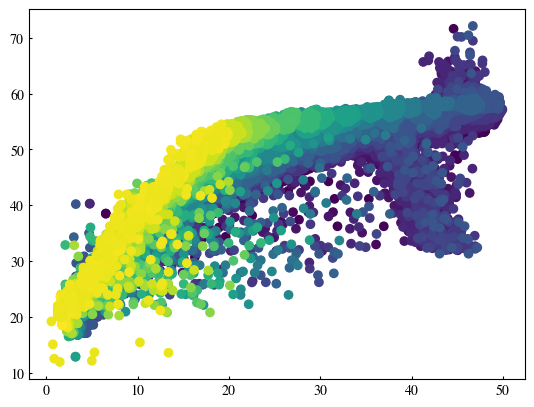

In [7]:
plt.scatter(data_clean.extrusion_force_N, data_clean.die_diameter_px, c=data_clean.hotend_temperature_C)

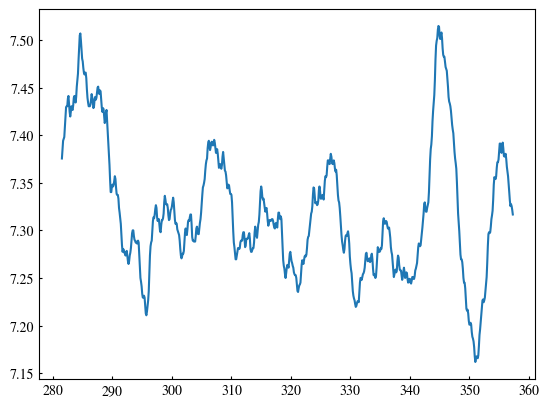

In [11]:
df = cleaned_steps[3]
plt.plot(df.time_s, df.extrusion_force_N)

In [23]:
dieswells, forces, Ts, Vs = [], [], [], []
for step in cleaned_steps:
    dieswells.append(step.die_diameter_px.mean())
    forces.append(step.extrusion_force_N.mean())
    Ts.append(step.hotend_temperature_C.mean())
    Vs.append(step.feedrate_mms.mean())

Text(0, 0.5, 'Die swell ratio')

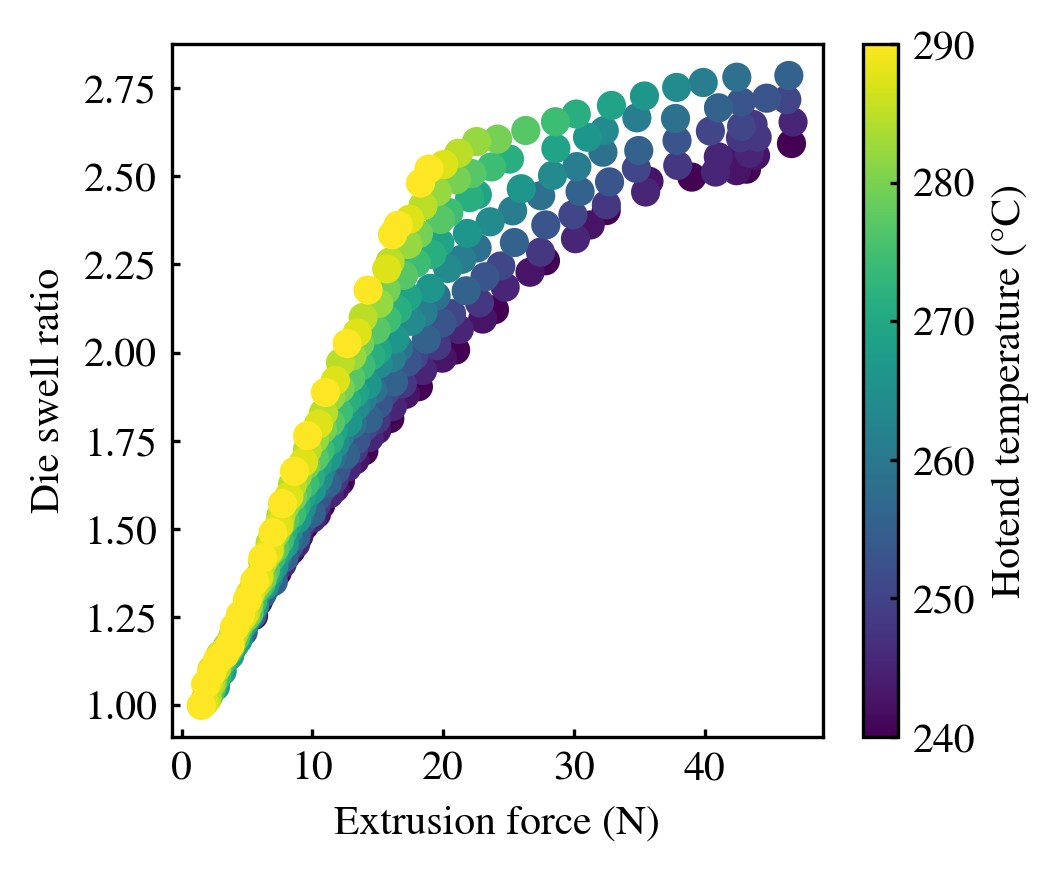

In [26]:
plt.figure(figsize=(3.5, 3), dpi=300)
plt.scatter(forces, np.array(dieswells)/np.array(dieswells).min(), c=Ts)
# plt.loglog()
plt.colorbar(label="Hotend temperature (°C)")
plt.xlabel("Extrusion force (N)")
plt.ylabel("Die swell ratio")